# Definice a importy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from IPython.display import clear_output

In [2]:
plt.rcParams['text.latex.preamble']=r"\usepackage{mlmodern}"
plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 11
plt.rcParams["font.family"] = 'mlmodern'
#plt.rcParams["mathtext.fontset"] = "cm"

In [575]:
%set_env QXToken=3995d18757f7a07fadfe6c00d94ce4d7aa20b35e38dc33f95f4023b0a7132918a8ed7b0a2c45a5f01e284d24f7145c1134071cc04a94f37cd7405e2420fff658

env: QXToken=3995d18757f7a07fadfe6c00d94ce4d7aa20b35e38dc33f95f4023b0a7132918a8ed7b0a2c45a5f01e284d24f7145c1134071cc04a94f37cd7405e2420fff658


In [2]:
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit_nature.second_q.circuit.library import UCC, UCCSD
from qiskit.quantum_info import Pauli
from qiskit.circuit import Parameter
from qiskit_ibm_runtime import QiskitRuntimeService, Session

from qiskit_nature.second_q.mappers import JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.operators import FermionicOp, PolynomialTensor

Usage: qc.draw('mpl', style = my_style)

In [3]:
my_style = {
"backgroundcolor" : "#111111",
"linecolor" : "#FFFFFF",
"textcolor": "#FFFFFF",
"gatetextcolor": "#FFFFFF" }

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [4]:
import tutorial_magics

%qiskit_version_table

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$ $$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\swch}[3]{\langle{#1} | #2 | {#3} \rangle} $$
$$\newcommand{\d}[]{\mathrm{d}}$$
$$\newcommand{\t}[1]{\mathrm{#1}}$$

# Charmonium Hamiltonian

## Formulace problému

Články:
- *Charmonium: The model*
- *Charmonium: the mass spectrum*
- *Properties of Low-Lying Charmonium States in a Phenomenological Approach*


Efektivní jednočásticový potenciál pro $c$ kvark uvězněný v dvoučásticovém $c \bar c$ nazývaný Cornell potential má podobu:
$$
\hat V = -\frac{\alpha_s}{r} + \sigma r
$$
Nerelativistický Hamiltonián pro $c$ kvark v $c \bar c$ tedy lze psát:
$$
\hat H = 2m_c + \hat T + \hat V = 2m_c -\frac{\nabla^2}{2\mu}+\sigma r -\frac{\alpha_s}{r}
$$
kde $\mu = \tfrac{m_c m_c}{m_c + m_c} = \tfrac{1}{2}m_c$ je redukovaná hmotnost pomocí které lze vyjádřit vnitřní kinetickou energii $c \bar c$, $m_c$ klidová hmotnost $c$ kvarku. Spolu s konstantami $\alpha_s$ a $\sigma$ jsou určeny experimentálně a lze je nalézt v tabulce.

Tabulka 1. Konstanty pro výpočty týkající se $c\bar c$:
$$
\begin{array}{cccccc}
\hline \hline \alpha_s & \sqrt{\sigma} & \mu & m_c & \omega & b \\
\hline 0.4038 & 441.6 MeV & 635 MeV & 1270 MeV &  571.5 MeV & 1.66 \times 10^{-3} MeV^{-1} \\
\hline
\end{array}
$$

Při řešení úlohy se omezíme pouze na stavy $c \bar c$ s $l=0$, tedy $s$ stavy. Hamiltonián v druhém kvantování bude mít při uvážení 3 orbitlů s nejnižší energií tvar:
$$
\hat H_3 = \sum_{N=0}^{2} \swch{m}{\hat H}{n} \hat a^\dagger_{m} \hat a^{\ }_n
$$
Orbitaly $\ket{n}$ volíme jako vlastní $s$ stavy Izotropního harmonického oscilátoru s frekvencí $\omega$. Užíváme soustavu jednotek $\hbar = 1$ a zavádíme charakteristickou délku oscilátoru jako $ b = (\mu \omega)^{-\tfrac{1}{2}} $

Stavy Izotropního Harmonického Oscilátoru (IHO) jsou popsány kvantovými čísly $n,l,m$ jako $\ket{n,l,m}$. Lze snadno přejít do sférické souřadnicové reprezentace a stavy tak vyjádřit pomocí vlnových funkcí $\Psi(r,\theta,\varphi)$:
$$ \Psi(r,\theta,\varphi) = \braket{r,\theta,\varphi\,}{\,n,l,m}$$

Hilbertův prostor tvořený těmito funkcemi lze rozložit na Hilbertův prostor kvadraticky integrabilních funkcí na polopřímce $\mathcal{H}_r$ a Hilbertův prostor kv. integrabilních funkcí na jednotkové kouli $\mathcal{H}_\Omega$. Pak $\mathcal{H} \sim \mathcal{H}_r \otimes \mathcal{H}_\Omega$ a vlnové funkce lze rozložit na součin radiální části a sférické části. 
$$\Psi(r,\theta,\varphi) = R_{n,l}(\xi)~Y_{l m}(\theta,\varphi),$$
kde $Y_{l m}(\theta,\varphi)$ jsou kulové funkce.

Kulové funkce mají obecně tvar:
$$ Y_{l m}(\theta,\varphi)=C_{l m}\;P_{l}^{m}(\cos\theta)\;e^{i m\varphi}, $$
kde $P_l^m$ jsou přidružené Legenderovy polynomy. Pro $l=0$ (a tudíž $m=0$) však platí:
$$ Y_{00}(\theta,\varphi)=\frac{1}{\sqrt{4\pi}} $$
Tudíž pro zde uvažované $s$ stavy (tj. $l=0$) je vlnová funkce $\Psi$ pouze funkcí $r$. Radiální část $R_{n,l}(r)$ vlnové funkce pro IHO má tvar:

$$ R_{n,l}(r)=K_{n l}\;\left(\tfrac{r}{b}\right)^{l}\;e^{-\frac{r^{2}}{2b^2}\;}\;L_{n}^{l+\frac{1}{2}}((\tfrac{r}{b})^{2}) $$
$$  K_{n l}=2 \pi^{-\frac{1}{4}} b^{-\frac{3}{2}}\left(\frac{2^{n+l}n!}{(2n+2l+1)!!}\right)^{\frac{1}{2}} $$
$$L_{n}^{\beta}(z)={\frac{1}{n!}}\;e^{z}z^{-\beta}\;{\frac{d^{n}}{d z^{n}}}\;\left(e^{-z}z^{n+\beta}\right)$$

Pro $ l=0 $ pak:
$$R_n(r) = R_{n,0}(r)=(-1)^{n}{\sqrt{{\frac{2n!}{b^{3}\,\Gamma(n+3/2)}}}}\exp\biggl(-{\frac{r^{2}}{2b^{2}}}\biggr)\,L_{n}^{1/2}\biggl({\frac{r^{2}}{b^{2}}}\biggr)\,, $$

kde $\Gamma$ je Eulerova gamma funkce.

## Maticové elementy

Výpočet  $H_{mn} = \swch{m}{\hat H}{n}$ lze rozdělit na několik částí:

$$H_{mn} = \swch{m}{\hat H}{n} = \swch{m}{\hat T}{n} + \swch{m}{\hat V}{n} = T_{mn} + V_{mn}.$$

Pro kinetickou energii $\hat T$ platí:

$$\hat T = \frac{1}{2\mu} \left( \frac{\d^2}{\d r^2} + \frac{2}{r} \frac{\d}{\d r} \right) = \frac{1}{2\mu} \frac{\d}{\d r} r^2 \frac{\d}{\d r}. $$

Maticový element $T_{mn}$ tak lze vyjádřit pomocí integrálu:

$$\swch{m\,}{\hat T}{\,n}  = (R_m|\hat T|R_n) = \frac{1}{2\mu} \int_{0}^{\infty} R_m \frac{\d}{\d r}\left( r^2 \frac{\d R_n}{\d r}\right) r^2 \mathrm{d}r, $$ 

kde integrace přes úhlovou část vlnových funkcí obdobně jako v případě maticových elementů potenciálu pro $l=0$ k výslednému integrálu nijak nepřispívá. Lze ji tak vynechat.

Maticový element potenciálu $V_{mn}$ lze rozložit dále. Potenciál $\hat V$ má tvar

$$\hat V = -\frac{\alpha_s}{r} + \sigma r.$$

Maticový element lze tedy dále rozložit na součet maticových elementů operátoru násobení $r$ a $r^{-1}$

$$ \swch{m}{\hat V}{n} = -\alpha_s \swch{m}{r^{-1}}{n} + \sigma \swch{m}{r}{n}.$$

Tyto maticové elementy jsou vyjádřeny integrály přes celý prostor prametrizovaný sférickými souřadnicemi. Jak již bylo naznačeno výše, vlnová funkce IHO pro $l=0$ závisí pouze na $r$. Integrací přes úhlové souřadnice je tedy získán celý prostorový úhel $4\pi$. Tento prostorový úhel je pak vykrácen druhou mocninou kulových funkcí v integrálu. Pro určení maticových elementů $r$ tak stačí pouze integrovat přes radiální souřadnici s přidáním $r^2$ z Jakobiánu sférických souřadnic

$$\swch{m\,}{r}{\,n} = \int_{0}^{2\pi} \int_{0}^{\pi} Y_{00}(\theta,\varphi)^2 \int_{0}^{\infty} R_{m,0}(r) R_{n,0}(r) \, r^{3}\sin\theta\,\mathrm{d}r\,\mathrm{d}\theta\,\mathrm{d}\varphi = \int_0^{4\pi} \tfrac{1}{4\pi} \mathrm{d}\Omega \int_{0}^{\infty} R_m R_n \, r^3 \mathrm{d}r = \int_{0}^{\infty} R_m R_n \, r^3 \mathrm{d}r. $$ 

Obdobně lze postupovat i pro $r^{-1}$

$$\swch{m\,}{r^{-1}}{\,n}  = \int_{0}^{\infty} R_m R_n \, r \mathrm{d}r.$$ 

### Vypocty se SymPy

In [5]:
from sympy.physics.sho import R_nl
from sympy.abc import m, n, r, nu, l, b, psi, omega
from sympy import Function, Symbol
from sympy import Integral, oo
from sympy import *

Knihovna sympy umoňuje symbolické výpočty. Radiální funkce IHO jsou v ní zahrnuty. Pro $l=0$ má tvar:

In [6]:
R_nl(n, 0, b**(-2)/2, r)

sqrt(2**(n + 2)*(b**(-2))**(3/2)*factorial(n)/factorial2(2*n + 1))*exp(-r**2/(2*b**2))*assoc_laguerre(n, 1/2, r**2/b**2)/pi**(1/4)

Integrály s $R_{nl}$ lze počítat následujícím způsobem: 

In [7]:
ksi = 1.66*10**(-3) ### Pouze preznacene b, pocitame v MeV a hbar=1
i = 0 ### Nastaveni m a n
j = 0

### Vypocet <0|r|0> a prenasobeni sigma
r00 = Integral(
    R_nl(i,j,ksi**(-2)/2,r)**2*r**3, 
    (r, 0, oo)
).n()*441.6**2

### Vypocet <0|r^-1|0> a prenasobeni alpha
invr00 = Integral(
    R_nl(i,j,ksi**(-2)/2,r)**2*r, 
    (r, 0, oo)
).n()*0.4038

print("Hodnota <{}|V|{}> je: {} MeV".format(i,j,r00 - invr00))

Hodnota <0|V|0> je: 90.7944852958506 MeV


### Výpočet $V_{mn} = \swch{m}{\hat V}{n}$

In [8]:
V = np.zeros((3,3))
ksi = 1.66*10**(-3)

for i in range(3):
    for j in range(3):
        i1 = Integral(R_nl(i,0,ksi**(-2)/2,r)*R_nl(j,0,ksi**(-2)/2,r)*r**3, (r, 0, oo)).n()
        i2 = Integral(R_nl(i,0,ksi**(-2)/2,r)*R_nl(j,0,ksi**(-2)/2,r)*r, (r, 0, oo)).n()
        v = (i1*441.6**2 - i2*0.4038)*(-1)**(i+j)
        print("V{}{} = {}".format(i,j,v), end = " ")
        if j==2: print("")
        V[i][j] = v

V00 = 90.7944852958506 V01 = 261.180006749393 V02 = -108.514885275498 
V10 = 261.180006749393 V11 = 319.179482029386 V12 = 316.718147446441 
V20 = -108.514885275498 V21 = 316.718147446441 V22 = 481.318841875256 


In [9]:
print(V)

[[  90.7944853   261.18000675 -108.51488528]
 [ 261.18000675  319.17948203  316.71814745]
 [-108.51488528  316.71814745  481.31884188]]


In [10]:
tab = V
print(tabulate(tab, tablefmt="latex_booktabs"))

\begin{tabular}{rrr}
\toprule
   90.7945 & 261.18  & -108.515 \\
  261.18   & 319.179 &  316.718 \\
 -108.515  & 316.718 &  481.319 \\
\bottomrule
\end{tabular}


Matice definovaná elementy $\hat V_{mn}$ má tak tvar:
$$ V_3 =
\begin{pmatrix*}[r]
   90.7945 & 261.18  & -108.515 \\
  261.18   & 319.179 &  316.718 \\
 -108.515  & 316.718 &  481.319 \\
\end{pmatrix*} \  \t{MeV}
$$

### Výpočet $T_{mn} = \swch{m}{\hat T}{n}$

Pro kinetickou energii $\hat T$ platí:

$$\hat T = \frac{1}{2\mu} \left( \frac{\d^2}{\d r^2} + \frac{2}{r} \frac{\d}{\d r} \right) = \frac{1}{2\mu} \frac{\d}{\d r} r^2 \frac{\d}{\d r}. $$

Maticový element $T_{mn}$ tak lze vyjádřit pomocí integrálu:

$$\swch{m\,}{\hat T}{\,n}  = (R_m|\hat T|R_n) = \frac{1}{2\mu} \int_{0}^{\infty} R_m \frac{\d}{\d r}\left( r^2 \frac{\d R_n}{\d r}\right) r^2 \mathrm{d}r, $$ 

kde integrace přes úhlovou část vlnových funkcí obdobně jako v případě maticových elementů potenciálu pro $l=0$ k výslednému integrálu nijak nepřispívá. Lze ji tak vynechat.

Takto definovaná matice má pásový (třídiagonální) tvar, to plyne z vlastností přidružených Laguerrových polynomů [wolfram](https://mathworld.wolfram.com/AssociatedLaguerrePolynomial.html), [tabulky](https://www.amazon.com/exec/obidos/ASIN/0486612724/ref=nosim/ericstreasuretro). 
Derivací Lguerrova polynomu lze vyjádřit pomocí Lauguerrových polynomů stejného a o jeden nižšího řádu
$$ \frac{d}{d\,x}\;L_{n}^{k}\left(x\right)=-\,L_{n-1}^{\left(k+1\right)}\,\left(x\right) =x^{-1}\left[n\,L_{n}^{k}\left(x\right)-\left(n+k\right)L_{n-1}^{k}\left(x\right)\right].$$
Derivaci funkce $R_{nl}$ tedy lze vyjádřit pomocí funkcí $R_{nl}$ a $R_{(n-1)l}$. Dále, integrál Laguerrových polynomů přenásobených exponenciálou argumentu, což je tvar na který lze funkce $R_{nl}$ a $R_{(n-1)l}$ převést lze vyjádřit jako: 
$$ \int_{0}^{\infty}e^{-x}\;x^{k}\;L_{n}^{k}\left(x\right)L_{m}^{k}\left(x\right)d\,x=\frac{\left(n+k\right)!}{n!}\;\delta_{m\,n}. $$

Pomocí těchto identit lze spočítat maticové elementy kinetické energie [článek](https://arxiv.org/abs/1512.03802):
$$
\swch{m,l \,}{\, \hat T \,}{\, n,l} =  \frac{\omega}{2}   \begin{cases}
        -\sqrt{n\left(n+l+{\frac{1}{2}}\right)} \qquad & m=n-1\\[.5em]
        \qquad \left(2n+l+\frac{3}{2}\right)  & m=n \\[.5em]
        -\sqrt{\left(n+1\right)\left(n+l+{\textstyle{\frac{3}{2}}}\right)} & m=n+1
    \end{cases}
$$
A pro $l=0$ tedy:
$$
\swch{m \,}{\, \hat T \,}{\, n} = \frac{\omega}{2} \left\{ \left(2n+\tfrac{3}{2}\right) \delta_{m,n} - \sqrt{n\left(n+{\tfrac{1}{2}}\right)} \ \delta_{m+1,n} - \sqrt{(n+1)\left(n+{\tfrac{3}{2}}\right)} \ \delta_{m-1,n} \right\}
$$

In [11]:
#omega = 571.49
omega = 562.9
from fractions import Fraction

def T_func(m,n):
    ### pro spravne hodnoty musi byt vynasobeno omega/2
    if n==m:
        return 2*n + 3/2
    elif (m+1)==n: 
        return -sqrt(n*(n+Fraction(1,2)))
    elif (m-1)==n:
        return -sqrt((n+1)*(n+Fraction(3,2)))
    else:
        return 0

In [12]:
T_func(2,1)

-sqrt(5)

In [13]:
T = np.zeros((3,3))

for i in range(3):
    for j in range(3):
        T[i,j] = T_func(i,j)

T_coeff = T
print(T_coeff)

[[ 1.5        -1.22474487  0.        ]
 [-1.22474487  3.5        -2.23606798]
 [ 0.         -2.23606798  5.5       ]]


In [14]:
T = T*omega/2
print(T)

[[ 422.175      -344.70444405    0.        ]
 [-344.70444405  985.075      -629.34133227]
 [   0.         -629.34133227 1547.975     ]]


In [15]:
tab = T
#print(tabulate(tab, tablefmt="latex_booktabs"))

Matice $T_3$ má tedy tvar:
$$
T_3 = \frac{\omega}{2}
\begin{pmatrix*}[c]
  \frac{3}{2} & -\tfrac{\sqrt{3}}{2} &    0     \\
 -\frac{\sqrt{3}}{2} &  \frac{7}{2} & \sqrt{5} \\
    0     & \sqrt{5} & \frac{11}{2}  \\
\end{pmatrix*} =
\begin{pmatrix*}[r]
  422.175 & -344.704 &    0     \\
 -344.704 &  985.075 & -629.341 \\
    0     & -629.341 & 1547.97  \\ 
\end{pmatrix*} \  \t{MeV}
$$

## Mapování z Fockova prostoru na prostor qubitů

Nyní je třeba Hamiltonián transformovat z formulace pomocí druhého kvantování na prostor qbitů. To lze snadno provést pomocí tříd a metod z knihovny **qiskit_nature**. Operátor vyjádřený fermionickými operátory lze reprezentovat jako instanci třídy **FermionicOp**. Poté lze použít zabudovanž **JordanWignerMapper** k transformaci na Pauliho řetězce.

Matice Hamiltoniánu je dána jako součet matice kinetické energie a potenciálu:

In [16]:
H = T + V
H

array([[ 512.9694853 ,  -83.5244373 , -108.51488528],
       [ -83.5244373 , 1304.25448203, -312.62318482],
       [-108.51488528, -312.62318482, 2029.29384188]])

In [17]:
mapper = JordanWignerMapper()
mapperB = BravyiKitaevMapper()

Následující funkce vytvoří instanci třídy **SparsePauliOp** představující operátory dané lineárními kombinacemi Pauliho řetězců: 

In [18]:
def Hamiltonian(Ham,mapper):

    data = {}
    data["+-"] = Ham
    tensor = PolynomialTensor(data)
    operator = FermionicOp.from_polynomial_tensor(tensor)
    pauli = mapper.map(operator)
    
    return pauli

def print_pauli(pauli):
    for i,j in zip(np.real(pauli.coeffs), pauli.paulis): print("{} {} ".format(i,j))

In [19]:
H_pauli = Hamiltonian(H, mapper)
print_pauli(Hamiltonian(H, mapper))

1923.258904600246 III 
-256.48474264792526 IIZ 
-41.762218651884865 IYY 
-41.762218651884865 IXX 
-54.257442637748944 YZY 
-54.257442637748944 XZX 
-652.1272410146928 IZI 
-156.31159241043719 YYI 
-156.31159241043719 XXI 
-1014.646920937628 ZII 


In [20]:
tab = np.array([H_pauli.paulis.to_labels(), np.real(H_pauli.coeffs).round(2)])

#print(tabulate(tab, tablefmt="latex_booktabs"))
print(tabulate(tab))

-------  -------  ------  ------  ------  ------  -------  -------  -------  --------
III      IIZ      IYY     IXX     YZY     XZX     IZI      YYI      XXI      ZII
1923.26  -256.48  -41.76  -41.76  -54.26  -54.26  -652.13  -156.31  -156.31  -1014.65
-------  -------  ------  ------  ------  ------  -------  -------  -------  --------


Hamiltonián vyjádřený pomocí Pauliho řetězců má tedy podobu:

$\begin{array}{|l|c|c|c|c|c|c|c|c|c|c|}
\hline 
\t{Řetězec} & III               & IIZ                 & IYY                 & IXX                 & YZY                 & XZX                 & IZI                & YYI                 & XXI                 & ZII                \\
 \hline
\t{Koeficient} & 1923.26 & -256.48 & -41.76 & -41.76 & -54.26 & -54.26 & -652.13 & -156.31 & -156.31 & -1014.65 \\
\hline
\end{array}$

## Ansatz

Výchozí stav $c\bar c$ je $\ket{100}$, tedy obsazený nejnižší stav. Chceme sestrojit ansatz $\hat U(\vec \theta)$, který aplikací na $\ket{100}$ umožní parametrizovat libovolný excitovaný stav pomocí parametrů $\vec \theta$. Použijeme UCC ansatz s jednoduchými excitacemi. Možné excitace jsou:
$$
\hat a^\dagger_1 \hat a_0, \  \hat a^\dagger_2 \hat a_0
$$
Excitační operátor $\hat T$ tak bude mít tvar:
$$
\hat T = \mathrm{e}^{\theta_1 \hat a^\dagger_1 \hat a_0 + \theta_2 \hat a^\dagger_2 \hat a_0}
$$
UCC ansatz pak bude mít následující tvar:
$$
\hat U(\theta_1,\theta_2) =  \mathrm{e}^{\hat T - \hat T^\dagger} = \exp \left[ \theta_1 (\hat a^\dagger_1 \hat a_0 - a^\dagger_0 \hat a_1) + \theta_2 (\hat a^\dagger_2 \hat a_0 - a^\dagger_0 \hat a_2) \right]
$$
V prvním řádu Trotterizace lze ansatz rozložit jako:
$$
\t{e}^{\theta_1 (\hat a^\dagger_1 \hat a_0 - a^\dagger_0 \hat a_1)} + \t{e}^{\theta_2 (\hat a^\dagger_2 \hat a_0 - a^\dagger_0 \hat a_2)}
$$
Jordan Wignerova transformaci $(\hat a^\dagger_1 \hat a_0 - a^\dagger_0 \hat a_1)$ a $(\hat a^\dagger_2 \hat a_0 - \hat a^\dagger_0 \hat a_2)$ lze opět získat užitím knihovny **qiskit_nature**:

In [21]:
op1 = FermionicOp(
    {
        "+_1 -_0": 1.0,
        "+_0 -_1": -1.0,
    },
    num_spin_orbitals=3,
)

exp1 = JordanWignerMapper().map(op1)

In [22]:
op2 = FermionicOp(
    {
        "+_2 -_0": 1.0,
        "+_0 -_2": -1.0,
    },
    num_spin_orbitals=3,
)

exp2 = JordanWignerMapper().map(op2)

In [23]:
print(exp1)
print(exp2)
ucc_exp = exp1+exp2
ucc_exp

SparsePauliOp(['IXY', 'IYX'],
              coeffs=[0.+0.5j, 0.-0.5j])
SparsePauliOp(['XZY', 'YZX'],
              coeffs=[0.+0.5j, 0.-0.5j])


SparsePauliOp(['IXY', 'IYX', 'XZY', 'YZX'],
              coeffs=[0.+0.5j, 0.-0.5j, 0.+0.5j, 0.-0.5j])

Ansatz po JW transformaci:
$$
\hat U(\theta_1, \theta_2) = \t{e}^{i\tfrac{\theta_1}{2}(IXY-IYX)} \t{e}^{i\tfrac{\theta_2}{2}(XZY-YZX)}
$$

Funkce, která vytvoří obvod odpovídající $\t{e}^{i\tfrac{\theta_2}{2}\hat P}$, kde $\hat P$ je Pauliho řetězec:

In [24]:
def pauli_exp_append(pauli_str,params = None, index = 0, pm = 1):

    if params == None:
        theta = Parameter("theta{}".format(index))
    else:
        theta = params[index]

    qc = QuantumCircuit(pauli_str.num_qubits, name="exp(ip{})".format(str(pauli_str)))
    num_q = pauli_str.num_qubits
    p = str(pauli_str)
    pr = str(pauli_str)[::-1]
    
    for i in range(num_q):

        if pr[i] == "X": 
            qc.h(i)
        elif pr[i] == "Y":
            qc.sdg(i)
            qc.h(i)
        else:
            pass

    for i in range(num_q-1,0,-1):

        if pr[i] == "I":
            pass
        else:
            j = i-1
            while j >= 0:
                if pr[j] == "I": 
                    j -= 1
                else:
                    qc.cx(i,j)
                    break
    i = 0
    while i < num_q:
        if pr[i] != "I":
            if pm == 1:
                qc.rz(theta, i)
            else:
                qc.rz(-theta, i)
            break
        else:
            i+=1


    for i in range(num_q-1):

        if pr[i] == "I":
            pass
        else:
            j = i+1
            while j < num_q:
                if pr[j] == "I": 
                    j += 1
                else:
                    qc.cx(j,i)
                    break
    
    for i in range(num_q):

        if pr[i] == "X": 
            qc.h(i)
        elif pr[i] == "Y":
            qc.h(i)
            qc.s(i)
        else:
            pass
        
    
    return qc

### UCC Ansatz

In [25]:
size = ucc_exp.size
sgn = np.sign(np.imag(ucc_exp.coeffs))
params = [Parameter("theta{}".format(i)) for i in range(size//2)]
params

[Parameter(theta0), Parameter(theta1)]

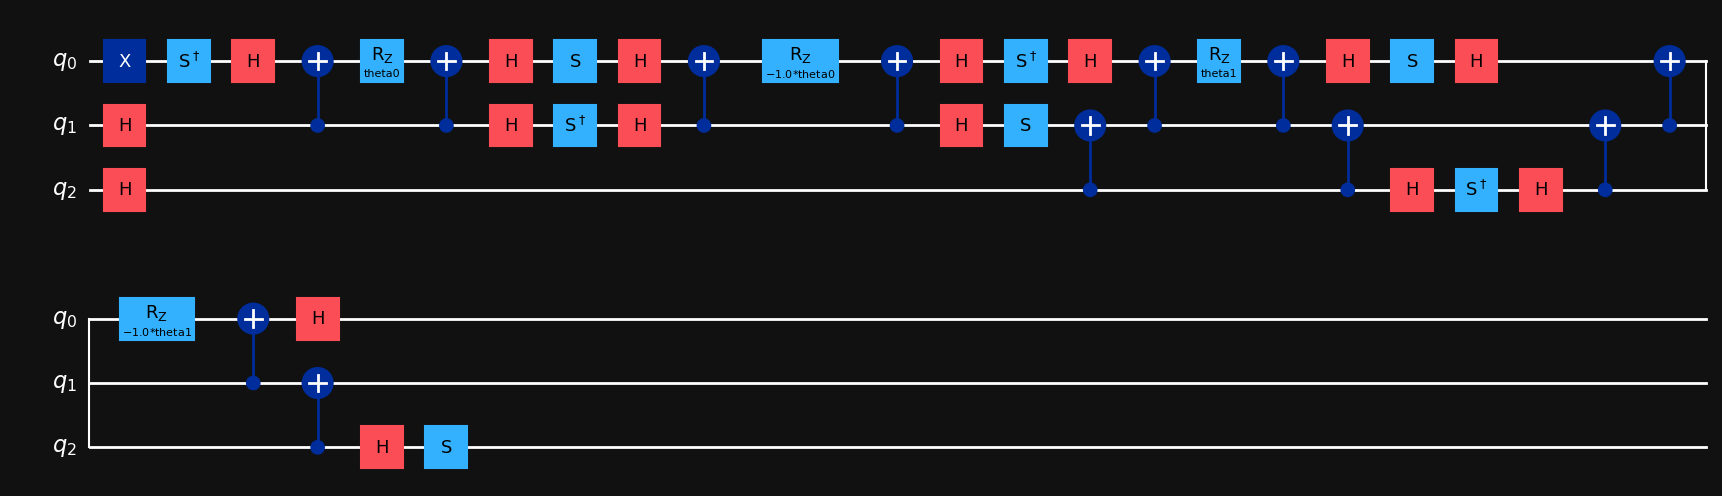

In [26]:
ansatz = QuantumCircuit(ucc_exp.num_qubits)
ansatz.x(0)

i = 0
for pauli in ucc_exp.paulis:
    ansatz.compose(pauli_exp_append(pauli, params = params, index = i//2, pm = sgn[i]) , inplace=True)
    i+=1

ansatz.draw("mpl", style=my_style)

In [27]:
qubit_mapper = JordanWignerMapper()
ucc = UCC(3, (1,0), 's', qubit_mapper,beta_spin=False)
#ucc.decompose().decompose().draw("mpl", style = my_style)

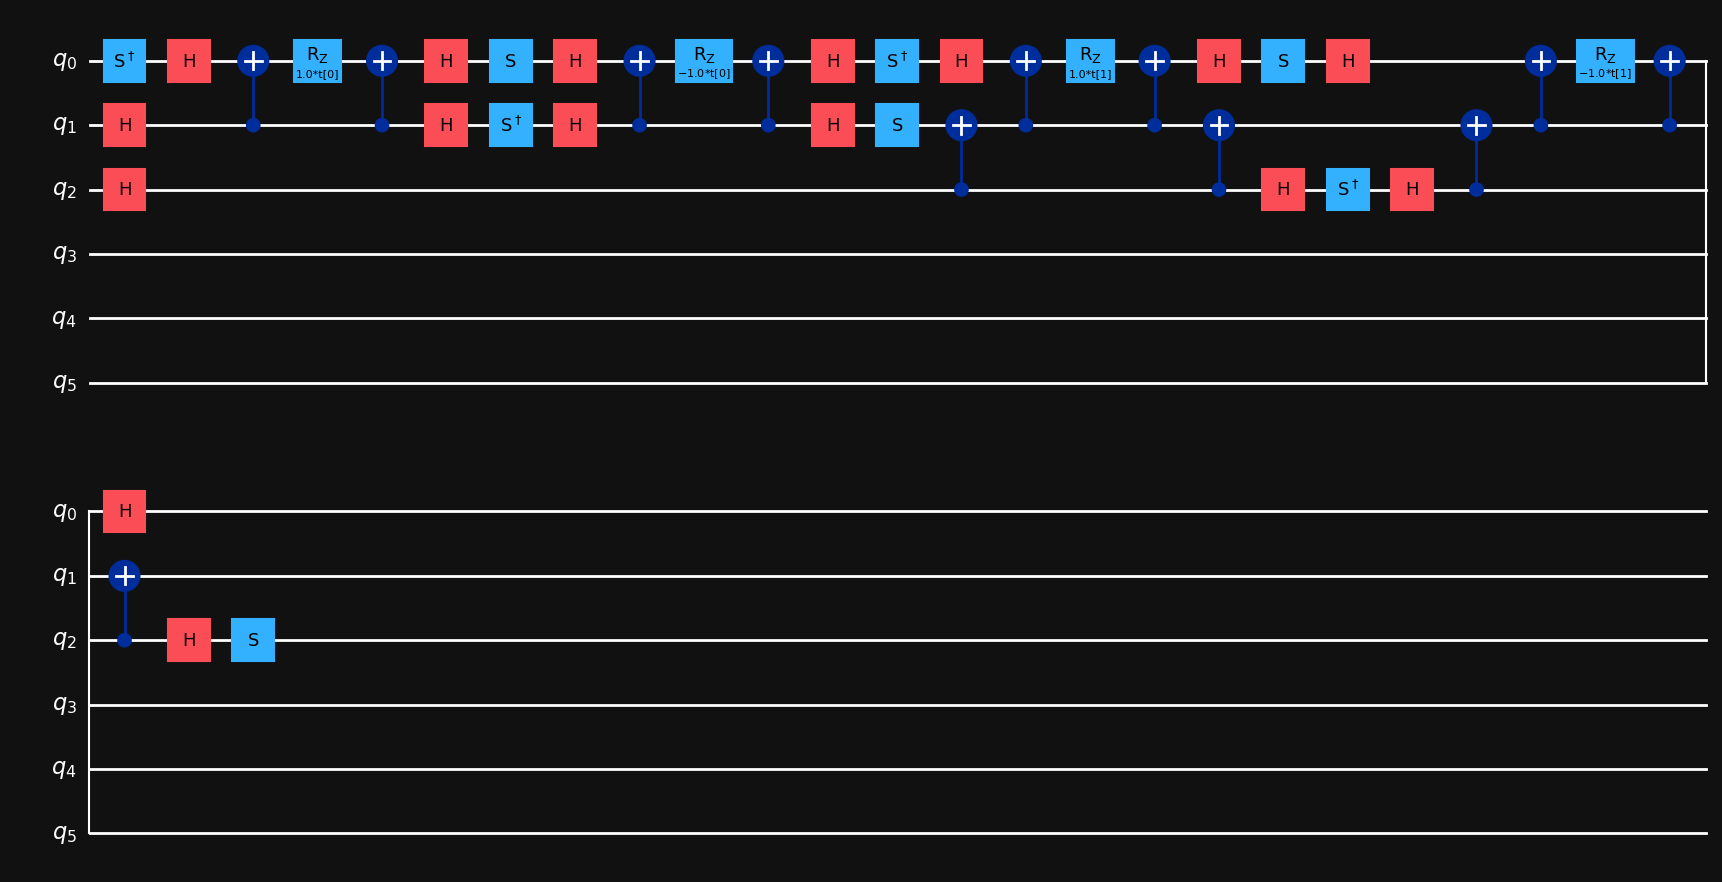

In [28]:
ucc.decompose().decompose().decompose().draw("mpl", style = my_style)

### EfficientSU2 Ansatz

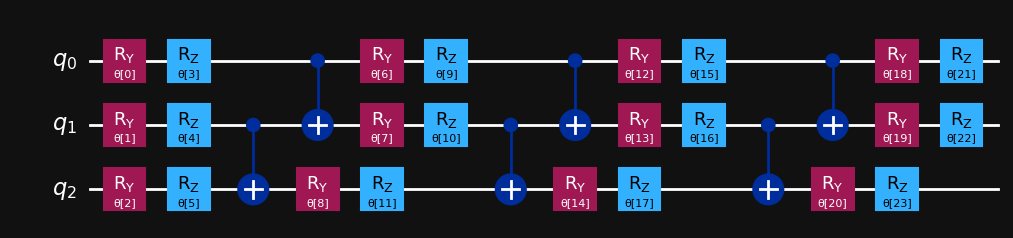

In [64]:
from qiskit.circuit.library import EfficientSU2

effsu2 = EfficientSU2(3)
effsu2.decompose().draw("mpl", style = my_style)

### TwoLocal Ansatz

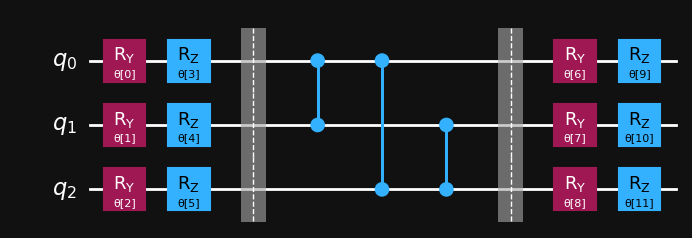

In [65]:
from qiskit.circuit.library import TwoLocal

num_qubits = 3
rotation_blocks = ['ry','rz']
entanglement_blocks = 'cz'
entanglement = 'full'

twolocal = TwoLocal(num_qubits, rotation_blocks, entanglement_blocks, entanglement, reps=1, insert_barriers=True)
num_params = ansatz.num_parameters

twolocal.decompose().draw('mpl', style = my_style)

# VQE

Zde probíhá nastavení backendu, buď simulátor kvantového počítače z IBM_runtime nebo AerSimulator. Dále lze zvolit fermion to qbit mapper.

In [31]:
mapper = JordanWignerMapper()
#mapper = BravyiKitaevMapper()

#service = QiskitRuntimeService(channel="ibm_quantum", token="3995d18757f7a07fadfe6c00d94ce4d7aa20b35e38dc33f95f4023b0a7132918a8ed7b0a2c45a5f01e284d24f7145c1134071cc04a94f37cd7405e2420fff658")
#backend = service.least_busy(operational=True, simulator=False)

#backend = FakeSherbrooke()
backend = AerSimulator()

H_pauli = Hamiltonian(H, mapper)
print_pauli(Hamiltonian(H, mapper))

1923.258904600246 III 
-256.48474264792526 IIZ 
-41.762218651884865 IYY 
-41.762218651884865 IXX 
-54.257442637748944 YZY 
-54.257442637748944 XZX 
-652.1272410146928 IZI 
-156.31159241043719 YYI 
-156.31159241043719 XXI 
-1014.646920937628 ZII 


In [32]:
backend.name

'aer_simulator'

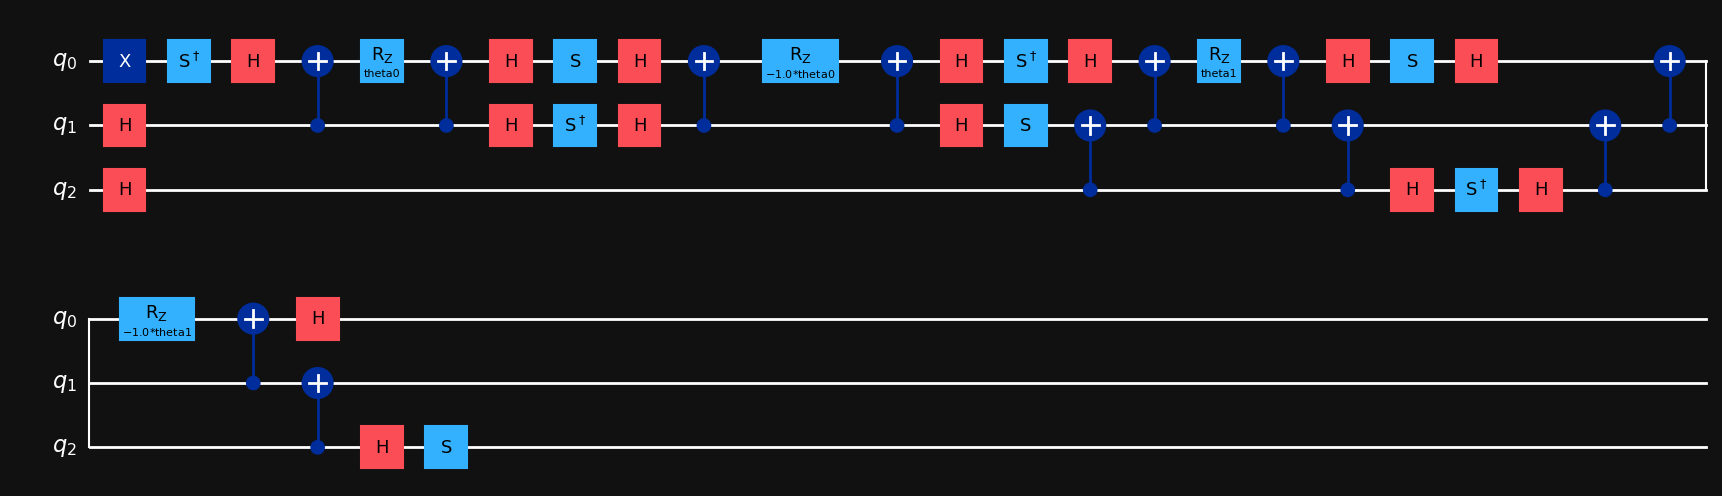

In [33]:
num_params = ansatz.num_parameters
ansatz.draw('mpl', style = my_style)
#print(ansatz.draw('latex_source'))

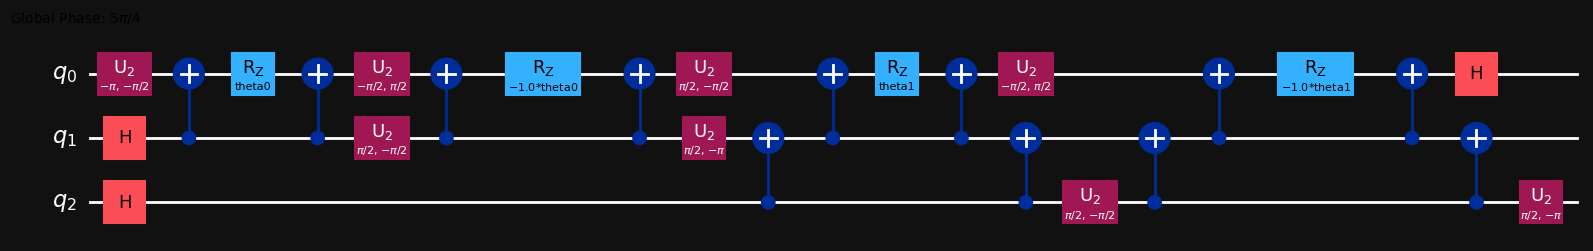

In [34]:
optimization_level_answer = 3 

pm = generate_preset_pass_manager(backend=backend,optimization_level=optimization_level_answer)

isa_circuit = pm.run(ansatz) 
isa_circuit.draw('mpl', idle_wires=False, style = my_style)

In [35]:
hamiltonian_isa = H_pauli.apply_layout(layout=isa_circuit.layout)
print_pauli(hamiltonian_isa)

1923.258904600246 III 
-256.48474264792526 IIZ 
-41.762218651884865 IYY 
-41.762218651884865 IXX 
-54.257442637748944 YZY 
-54.257442637748944 XZX 
-652.1272410146928 IZI 
-156.31159241043719 YYI 
-156.31159241043719 XXI 
-1014.646920937628 ZII 


In [36]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict, verbose = True):

    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(energy)
    callback_dict["result"].append(result)

    if verbose == True:
        if callback_dict["iters"] % 10 + 1 == 1:
            print("Iterace {}: {} MeV ".format(callback_dict["iters"], energy))
    
    return energy, result

def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

### Manual run

In [478]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "result": []
}

x0 = 2 * np.pi * np.random.random(num_params)
x0

array([6.20000887, 1.71139191])

In [480]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method="cobyla",
        options={'maxiter': 100})

Iterace 40: 577.4626342402482 MeV 
Iterace 50: 492.69060469355225 MeV 
Iterace 60: 494.8618153631958 MeV 


**AER SIMULÁTOR SE ŠUMEM**

In [ ]:
#backend = FakeSherbrooke()
#backend = AerSimulator()

callback_dict2 = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "result": []
}

aer = AerSimulator.from_backend(backend)
#aer=AerSimulator()
estimator = Estimator(mode=aer)

res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict2),
        method="Nelder-Mead",
        options={'maxiter': 100})

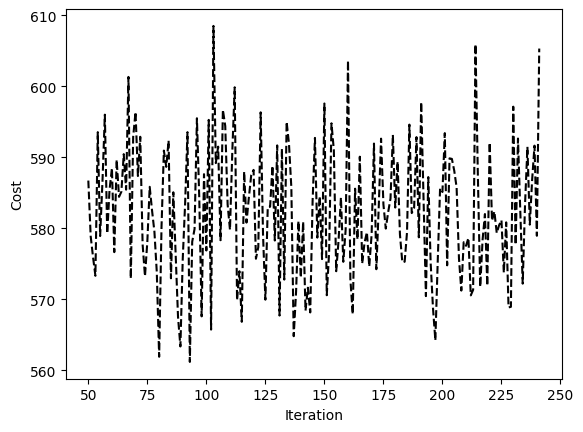

In [367]:
fig, ax = plt.subplots()
plt.plot(range(callback_dict["iters"])[50:-1], callback_dict["cost_history"][50:-1],linestyle="dashed", color = "k")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.draw()

In [404]:
stds = np.array([callback_dict["result"][i][0].data.stds[0] for i in range(callback_dict["iters"])])
evs = np.array([callback_dict["result"][i][0].data.evs[0] for i in range(callback_dict["iters"])])
run = 1

In [405]:
energy = res["fun"]
meas_err = stds[np.where(evs == res["fun"])[0][0]]

In [406]:
print("Run {}: Dosaženo minima {} +- {} MeV".format(run, energy.round(0), meas_err.round(0) ))

Run 1: Dosaženo minima 510.0 +- 6.0 MeV


In [383]:
optimizer = "Nelder-Mead"

In [387]:
np.savetxt("./data/run_{}_{}.csv".format(run,optimizer), np.array([evs,stds]).T , delimiter = ",")

### Automatized run:

In [ ]:
#optimizer = "cobyla"
optimizer = "Nelder-Mead"
name = backend.name

experiment = "omega562"
batch_size = 25
iters = 500

result = []

for run in range(batch_size):
    
    callback_dict_auto = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "result": []
    }

    x0 = 2 * np.pi * np.random.random(num_params)

    with Session(backend=backend) as session:
        estimator = Estimator(mode=session)
        estimator.options.default_shots = 1000

        res = minimize(
            cost_func_2,
            x0,
            args=(isa_circuit, hamiltonian_isa, estimator, callback_dict_auto, False),
            method=optimizer,
            options={'maxiter': iters},)

    stds = np.array([callback_dict_auto["result"][i][0].data.stds[0] for i in range(callback_dict_auto["iters"])])
    evs = np.array([callback_dict_auto["result"][i][0].data.evs[0] for i in range(callback_dict_auto["iters"])])
    
    energy = res["fun"]
    meas_err = stds[np.where(evs == res["fun"])[0][0]]

    result.append(np.array([energy, meas_err]))

    print("Run {}: Dosaženo minima {} +- {} MeV".format(run, energy.round(0), meas_err.round(0) ))

    #np.savetxt("./data/{}_{}_run_{}_{}.csv".format(experiment,name,run,optimizer), np.array([evs,stds]).T , delimiter = ",")


np.savetxt("./data/{}_{}_{}.csv".format(experiment,name,optimizer), np.array(result) , delimiter = ",")
    

Run 0: Dosaženo minima 1107.0 +- 30.0 MeV
Run 1: Dosaženo minima 463.0 +- 9.0 MeV


In [563]:
result_np = np.array(result).T

print("Výsledná hodnota jest {} +- {}".format( np.mean(reject_outliers(result_np[0])).round(1), np.std(reject_outliers(result_np[0])).round(1) ) )

Výsledná hodnota jest 610.8 +- 160.5


In [560]:
print( np.mean(reject_outliers(result_np[0])) )
print( np.std(reject_outliers(result_np[0])) )
print( np.sqrt(np.sum(result_np[1]**2))/100 )

501.74837596723427
16.520645634761287
2.249608722617421


In [564]:
reject_outliers(result_np[0])

array([489.10173849, 478.56210133, 481.75900166, 782.32156966,
       482.23254248, 914.84612687, 565.90798705, 791.29819533,
       511.54359017])

### one run

In [446]:
optimizer = "cobyla"
#optimizer = "Nelder-Mead"
iters = 100
experiment = "test"



run = 1

callback_dict_auto = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "result": []
}

x0 = 2 * np.pi * np.random.random(num_params)

with Session(backend=backend) as session:
    estimator = Estimator(mode=session)

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict_auto),
        method=optimizer,
        options={'maxiter': iters},)

Iterace 10: 513.5380924280869 MeV 
Iterace 20: 503.16942124836953 MeV 
Iterace 30: 502.2578954847355 MeV 


In [447]:
stds = np.array([callback_dict_auto["result"][i][0].data.stds[0] for i in range(callback_dict_auto["iters"])])
evs = np.array([callback_dict_auto["result"][i][0].data.evs[0] for i in range(callback_dict_auto["iters"])])

In [448]:
energy = res["fun"]
meas_err = stds[np.where(evs == res["fun"])[0][0]]

In [449]:
print("Run {}: Dosaženo minima {} +- {} MeV".format(run, energy.round(0), meas_err.round(0) ))

Run 1: Dosaženo minima 503.0 +- 7.0 MeV


In [451]:
np.savetxt("./data/{}_run_{}_{}.csv".format(experiment,run,optimizer), np.array([evs,stds]).T , delimiter = ",")

### <span style="font-size:2em;">VÝSLEDKY</span>

**RESULTS:**
Výskedná hodnota odpovídá základnímu stavu Hamiltoniánu bez klidové hmotnosti $c$ a $\bar c$ kvarku. Jde tedy o "vazebnou energii" $c \bar c$. Hmotnost charmonia získáme přičtením klidových hmotností $m_c = m_{\bar c} = 1270 \pm 20$ Mev.

- Bez šumu, použit Qskit Aer backend, 100 iterací, NelderMead optimizér:
   $$ B_{c\bar c} = 496 \pm 6 \, \textrm{MeV} \quad E_0 = 3036 \pm 29 \, \t{MeV} $$ 
- Se šumem, simulace počitače IBM Sherbrooke, COBYLA optimizér, 100 iterací:
  $$ B_{c\bar c} = 583 \pm 10 \, \textrm{MeV} \quad E_0 = 3123 \pm 30 \, \t{MeV} $$
- Pro srovnání spin averaged mass $J/\psi (1s)$ a $\eta_c(1s)$:
  $$ E_0 = \frac{1}{4}(3M_{J/\psi} + M_{\eta_c}) = 3068.5 \pm 0.1 \, \t{MeV}$$

<span style="font-size:3em;">KONEC. Zde jsou draci.</span>

In [ ]:
import spsa
#backend = FakeSherbrooke()
#backend = AerSimulator()

callback_dict3 = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "result": []
}

def cost_func_3(x):
    energy, result = cost_func(x,isa_circuit, hamiltonian_isa, estimator, callback_dict3)
    return energy

aer = AerSimulator.from_backend(backend)
#aer=AerSimulator()
estimator = Estimator(mode=aer)

spsa.minimize(
        cost_func_3,
        x0,
        iterations=1000
)

In [549]:
mat = np.real(np.array(H_pauli))

evalue, evect = np.linalg.eig(mat) 

evalue.round(1)

array([3356.1, 2639.2, 1697.8,  490.5, 2148.7, 1207.3,    0. , 3846.5])

### Extra LaTeX



$$\psi_{n l m}(r,\theta,\phi)=N\left(\frac{r}{b}\right)^{l}L_{n}^{l+1/2}(\frac{r}{b})e x p\left(-\frac{r^{2}}{2b^{2}}\right)Y_{l m}(\theta,\phi)$$
$$ |N|^{2}=\frac{2\alpha^{3}n!}{\sqrt{\pi}}\frac{2^{(2(n+l)+1)}}{(2n+2l+1)!}(n+l)!$$



VQE Článek:
$$ \langle r|n\rangle=(-1)^{n}{\sqrt{{\frac{2n!}{b^{3}\,\Gamma(n+3/2)}}}}\exp\biggl(-{\frac{r^{2}}{2b^{2}}}\biggr)\,L_{n}^{1/2}\biggl({\frac{r^{2}}{b^{2}}}\biggr)\,, $$

Tahák:

$$\psi_{n,l,m}(\xi,\theta,\varphi)=R_{n,l}(\xi)~Y_{l m}(\theta,\varphi)$$
$$ R_{n,l}(\xi)=K_{n l}\;\xi^{l}\;e^{-\frac{\xi^{2}}2\;}\;L_{n}^{l+\frac{1}{2}}(\xi^{2}) $$
$$ \xi=r\sqrt{\frac{M\omega}{\hbar}},\ \ \ K_{n l}=\frac{2}{\pi^{\frac{1}{4}}}\left(\frac{M\omega}{\hbar}\right)^{\frac{3}{4}}\left(\frac{2^{n+l}n!}{(2n+2l+1)!!}\right)^{\frac{1}{2}} $$
$$L_{n}^{\beta}(z)={\frac{1}{n!}}\;e^{z}z^{-\beta}\;{\frac{d^{n}}{d z^{n}}}\;\left(e^{-z}z^{n+\beta}\right)$$
$$ {L}_{0}^{\beta}(z)=1,\ {L}_{1}^{\beta}(z)=1+\beta-z $$

Kulové funkce:
$$ Y_{l m}(\theta,\varphi)=C_{l m}\;P_{l}^{m}(\cos\theta)\;e^{i m\varphi}, $$
kde $P_l^m$ jsou přidružené Legenderovy polynomy. Pro $l=0$ (a tudíž $m=0$) však platí:
$$ Y_{00}(\theta,\varphi)=\frac{1}{\sqrt{4\pi}} $$